## Initial imports

In [1]:
from scm.plams import plot_molecule
import scm.plams as plams
from scm.params import ParAMSJob, ResultsImporter
import glob
import matplotlib.pyplot as plt

## Initialize PLAMS environment

In [2]:
plams.init()

PLAMS working folder: /home/hellstrom/temp/grouptalk-VeN-2024-Feb-19/plams_workdir.010


## Run a quick reference MD job for liquid Ar

In this example we generate some simple reference data.

If you 

* already have reference data in the ParAMS .yaml format, then you can skip this step
* already have reference data in the ASE .xyz or .db format, you can convert it to the ParAMS .yaml format. See the section "Convert ASE format to ParAMS" below

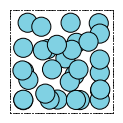

In [3]:
molecule = plams.Molecule(numbers=[18], positions=[(0, 0, 0)])
box = plams.packmol(molecule, n_atoms=32, density=1.4, tolerance=3.0)
plot_molecule(box)

In [4]:
reference_engine_settings = plams.Settings()
reference_engine_settings.runscript.nproc = 1
reference_engine_settings.input.ForceField.Type = "UFF"
md_job = plams.AMSNVTJob(
    settings=reference_engine_settings,
    molecule=box,
    name="uff_md",
    nsteps=5000,
    temperature=500,
    writeenginegradients=True,
    samplingfreq=500,
)
md_job.run();

[19.02|16:41:44] JOB uff_md STARTED
[19.02|16:41:44] JOB uff_md RUNNING
[19.02|16:41:46] JOB uff_md FINISHED
[19.02|16:41:46] JOB uff_md SUCCESSFUL


## Import reference results with ParAMS ResultsImporter

Here we use the ``add_trajectory_singlepoints`` results importer. For more details about usage of the results importers, see the corresponding tutorials.

In [5]:
ri = ResultsImporter(settings={"units": {"energy": "eV", "forces": "eV/angstrom"}})
ri.add_trajectory_singlepoints(md_job.results.rkfpath(), properties=["energy", "forces"])
# feel free to add other trajectories as well:
# ri.add_trajectory_singlepoints(job2.results.rkfpath(), properties=["energy", "forces"])   # etc...

["energy('uff_md_frame001')",
 "energy('uff_md_frame002')",
 "energy('uff_md_frame003')",
 "energy('uff_md_frame004')",
 "energy('uff_md_frame005')",
 "energy('uff_md_frame006')",
 "energy('uff_md_frame007')",
 "energy('uff_md_frame008')",
 "energy('uff_md_frame009')",
 "energy('uff_md_frame010')",
 "energy('uff_md_frame011')",
 "forces('uff_md_frame001')",
 "forces('uff_md_frame002')",
 "forces('uff_md_frame003')",
 "forces('uff_md_frame004')",
 "forces('uff_md_frame005')",
 "forces('uff_md_frame006')",
 "forces('uff_md_frame007')",
 "forces('uff_md_frame008')",
 "forces('uff_md_frame009')",
 "forces('uff_md_frame010')",
 "forces('uff_md_frame011')"]

## Optional: split into training/validation sets

Machine learning potentials in ParAMS can only be trained if there is both a training set and a validation set.

If you do not specify a validation set, the training set will automatically be split into a training and validation set when the parametrization starts.

Here, we will manually split the data set ourselves.

Let's first print the information in the current ResultsImporter training set:

In [6]:
def print_data_set_summary(data_set, title):
    number_of_entries = len(data_set)
    jobids = data_set.jobids
    number_of_jobids = len(jobids)
    print(f"{title}:")
    print(f"    number of entries: {number_of_entries}")
    print(f"    number of jobids: {number_of_jobids}")
    print(f"    jobids: {jobids}")


print_data_set_summary(ri.data_sets["training_set"], "Original training set")

Original training set:
    number of entries: 22
    number of jobids: 11
    jobids: {'uff_md_frame004', 'uff_md_frame007', 'uff_md_frame003', 'uff_md_frame009', 'uff_md_frame001', 'uff_md_frame010', 'uff_md_frame011', 'uff_md_frame006', 'uff_md_frame005', 'uff_md_frame002', 'uff_md_frame008'}


Above, the number of entries is twice the number of jobids because the ``energy`` and ``forces`` extractors are separate entries.

The energy and force extractors for a given structure (e.g. frame006) must belong to the same data set. For this reason, when doing the split, we call ``split_by_jobid``

In [7]:
training_set, validation_set = ri.data_sets["training_set"].split_by_jobids(0.8, 0.2, seed=314)
ri.data_sets["training_set"] = training_set
ri.data_sets["validation_set"] = validation_set

print_data_set_summary(ri.data_sets["training_set"], "New training set")
print_data_set_summary(ri.data_sets["validation_set"], "New validation set")

New training set:
    number of entries: 16
    number of jobids: 8
    jobids: {'uff_md_frame004', 'uff_md_frame007', 'uff_md_frame001', 'uff_md_frame010', 'uff_md_frame011', 'uff_md_frame006', 'uff_md_frame005', 'uff_md_frame008'}
New validation set:
    number of entries: 6
    number of jobids: 3
    jobids: {'uff_md_frame009', 'uff_md_frame002', 'uff_md_frame003'}


## Store the reference results in ParAMS yaml format

Use ``ResultsImporter.store()`` to store all the data in the results importer in the ParAMS .yaml format:

In [8]:
yaml_dir = "yaml_ref_data"
ri.store(yaml_dir, backup=False)

# print the contents of the directory
for x in glob.glob(f"{yaml_dir}/*"):
    print(x)

yaml_ref_data/results_importer_settings.yaml
yaml_ref_data/validation_set.yaml
yaml_ref_data/job_collection_engines.yaml
yaml_ref_data/training_set.yaml
yaml_ref_data/job_collection.yaml


## Set up and run a ParAMSJob for training ML Potentials

See the ParAMS MachineLearning documentation for all available input options.

Training the model may take a few minutes.

In [9]:
job = ParAMSJob.from_yaml(yaml_dir)
job.name = "params_training_ml_potential"
job.settings.input.Task = "MachineLearning"
job.settings.input.MachineLearning.CommitteeSize = 1  # train only a single model
job.settings.input.MachineLearning.MaxEpochs = 200
job.settings.input.MachineLearning.LossCoeffs.Energy = 10
job.settings.input.MachineLearning.Backend = "M3GNet"
job.settings.input.MachineLearning.M3GNet.Model = "UniversalPotential"
job.settings.input.MachineLearning.Target.Forces.Enabled = "No"
job.settings.input.MachineLearning.RunAMSAtEnd = "Yes"

In [10]:
job.run();

[19.02|16:41:46] JOB params_training_ml_potential STARTED
[19.02|16:41:47] JOB params_training_ml_potential RUNNING
[19.02|16:43:05] JOB params_training_ml_potential FINISHED
[19.02|16:43:05] JOB params_training_ml_potential SUCCESSFUL


## Results of the ML potential training

Use ``job.results.get_running_loss()`` to get the loss value as a function of epoch:

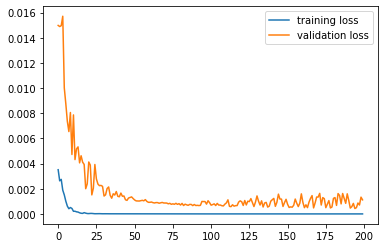

In [11]:
epoch, training_loss = job.results.get_running_loss(data_set="training_set")
plt.plot(epoch, training_loss)

epoch, validation_loss = job.results.get_running_loss(data_set="validation_set")
plt.plot(epoch, validation_loss)
plt.legend(["training loss", "validation loss"]);

If you set ``MachineLearning%RunAMSAtEnd`` (it is on by default), this will run the ML potential through AMS at the end of the fitting procedure, similar to the ParAMS SinglePoint task.

This will give you access to more results, for example the predicted-vs-reference energy and forces for all entries in the training and validation set. Plot them in a scatter plot like this:

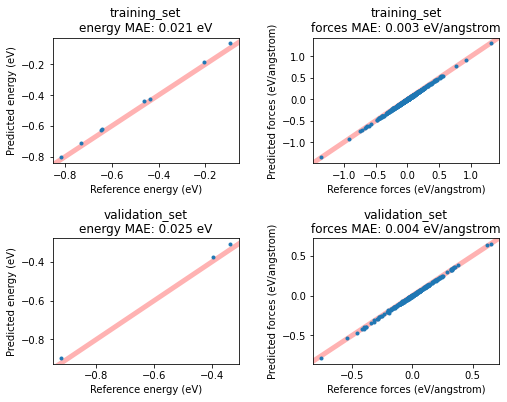

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))

for i, data_set in enumerate(["training_set", "validation_set"]):
    for j, key in enumerate(["energy", "forces"]):
        dse = job.results.get_data_set_evaluator(data_set=data_set, source="best")
        data = dse.results[key]
        ax = axes[i][j]
        ax.plot(data.reference_values, data.predictions, ".")
        ax.set_xlabel(f"Reference {key} ({data.unit})")
        ax.set_ylabel(f"Predicted {key} ({data.unit})")
        ax.set_title(f"{data_set}\n{key} MAE: {data.mae:.3f} {data.unit}")
        ax.set_xlim(auto=True)
        ax.autoscale(False)
        ax.plot([-10, 10], [-10, 10], linewidth=5, zorder=-1, alpha=0.3, c="red")

plt.subplots_adjust(hspace=0.6, wspace=0.4)

## Get the engine settings for production jobs

First, let's find the path to where the trained m3gnet model resides using ``get_deployed_model_paths()``. This function returns a list of paths to the trained models. In this case we only trained one model, so we access the first element of the list with ``[0]``:

In [13]:
print(job.results.get_deployed_model_paths()[0])

/home/hellstrom/temp/grouptalk-VeN-2024-Feb-19/plams_workdir.010/params_training_ml_potential/results/optimization/m3gnet/m3gnet


The above is the path we need to give as the ``ParameterDir`` input option in the AMS MLPotential engine. For other backends it might instead be the ``ParameterFile`` option.

To get the complete engine settings as a PLAMS Settings object, use the method ``get_production_engine_settings()``:

In [14]:
production_engine_settings = job.results.get_production_engine_settings()
print(plams.AMSJob(settings=production_engine_settings).get_input())

Engine MLPotential
  Backend M3GNet
  MLDistanceUnit angstrom
  MLEnergyUnit eV
  Model Custom
  ParameterDir /home/hellstrom/temp/grouptalk-VeN-2024-Feb-19/plams_workdir.010/params_training_ml_potential/results/optimization/m3gnet/m3gnet
EndEngine




## Run a short MD simulation with the trained potential

In [15]:
production_engine_settings.runscript.nproc = 1  # run AMS Driver in serial
new_md_job = plams.AMSNVTJob(
    settings=production_engine_settings,
    molecule=box,
    nsteps=5000,
    temperature=300,
    samplingfreq=100,
    name="production_md",
    timestep=1.0,
)
new_md_job.run(watch=True);

[19.02|16:43:05] JOB production_md STARTED
[19.02|16:43:05] JOB production_md RUNNING
[19.02|16:43:06] production_md: AMS 2024.101  RunTime: Feb19-2024 16:43:06  ShM Nodes: 1  Procs: 1
[19.02|16:43:09] production_md: Starting MD calculation:
[19.02|16:43:09] production_md: --------------------
[19.02|16:43:09] production_md: Molecular Dynamics
[19.02|16:43:09] production_md: --------------------
[19.02|16:43:09] production_md:          Step       Time    Temp.         E Pot        Pressure        Volume
[19.02|16:43:09] production_md:                     (fs)      (K)          (au)           (MPa)         (A^3)
[19.02|16:43:15] production_md:             0       0.00     300.      -0.00672        1048.733        1516.2
[19.02|16:43:22] production_md:           100     100.00     321.      -0.00954        1012.718        1516.2
[19.02|16:43:23] production_md:           200     200.00     429.      -0.02531         767.602        1516.2
[19.02|16:43:24] production_md:           300     3

## Open trajectory file in AMSmovie
With the production trajectory you can run analysis tools in AMSmovie, or access them from Python. See the AMS manual for details.

In [19]:
trajectory_file = new_md_job.results.rkfpath()
!amsmovie "{trajectory_file}"

## Finish PLAMS

In [17]:
plams.finish()

[19.02|16:44:24] PLAMS run finished. Goodbye
